# Error Detection using LSTMs
This notebook demonstrates how we use record embeddings to perform error detection in tuples. We are using the **Hospital** dataset which has been artificially augmented to contain the following type of errors:
1. The cell values have been shuffled across the columnar axis.
2. 5% of tuples has a cell value assigned to NaN.
3. 10% of the tuples has a cell value misspelt.

By converting each tuple to a space separated string and feeding it to an LSTM, we see if the network can learn to detect errors in the tuples.

In [154]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import h5py
import pickle
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import models
from keras import layers
from keras import optimizers
from keras import activations
from keras import losses
from keras import metrics
from keras.utils import to_categorical

import matplotlib.pyplot as plt
%matplotlib inline

## Read the data

In [155]:
df = pd.read_csv('final_4k_tuples.csv', encoding='utf8')

In [156]:
df.head(2)

,ProviderNumber,HospitalName,Address1,City,State,ZipCode,CountyName,PhoneNumber,label
0,10039,HUNTSVILLE HOSPITAL,101 SIVLEY RD,HUNTSVILLE,AL,35801,MADIKON,2562651000,misspellings
1,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3342228466,shuffling


In [157]:
len(df)

4000

In [158]:
df['label'].value_counts()

misspellings    1000
truth           1000
empty           1000
shuffling       1000
Name: label, dtype: int64

### Some preprocessing to replace phoneNumber and providerNumber with a 0 instead of NaN

In [159]:
df['PhoneNumber'].fillna(0, inplace=True)
df['ProviderNumber'].fillna(0, inplace=True)
df['ZipCode'].fillna(0, inplace=True)

In [160]:
df.head(2)

,ProviderNumber,HospitalName,Address1,City,State,ZipCode,CountyName,PhoneNumber,label
0,10039,HUNTSVILLE HOSPITAL,101 SIVLEY RD,HUNTSVILLE,AL,35801,MADIKON,2562651000,misspellings
1,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3342228466,shuffling


### Separate the labels from the training data

In [161]:
df['label'] = df['label'].astype('category')

In [162]:
df["Label_Cat"] = df["label"].cat.codes

In [163]:
df.head()

,ProviderNumber,HospitalName,Address1,City,State,ZipCode,CountyName,PhoneNumber,label,Label_Cat
0,10039,HUNTSVILLE HOSPITAL,101 SIVLEY RD,HUNTSVILLE,AL,35801,MADIKON,2562651000,misspellings,1
1,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3342228466,shuffling,2
2,10035,CULLMAN REGIONAL MEDICAL CENTER,1912 ALABAMA HIGHWAY 157,CULLMAN,RL,35058,CULLMAN,2567372000,misspellings,1
3,10029,EAST ALABAMA MEDICAL CENTER AND SNF,2000 PEPPERELL PARKWAY,OPELIKA,AL,36801,0,3347493411,empty,0
4,10044,MARION REGIONAL FEDICAL CENTER,1256 MILITARY STREET SOUTH,HAMILTON,AL,35570,MARION,2059216200,misspellings,1


In [164]:
df['Label_Cat'].value_counts()

3    1000
1    1000
2    1000
0    1000
Name: Label_Cat, dtype: int64

Get the mapping

In [165]:
mapping = dict(enumerate(df['label'].cat.categories))

In [166]:
mapping

{0: 'empty', 1: 'misspellings', 2: 'shuffling', 3: 'truth'}

In [167]:
df.drop(columns=['label'], axis=1, inplace=True)

In [168]:
df.head(2)

,ProviderNumber,HospitalName,Address1,City,State,ZipCode,CountyName,PhoneNumber,Label_Cat
0,10039,HUNTSVILLE HOSPITAL,101 SIVLEY RD,HUNTSVILLE,AL,35801,MADIKON,2562651000,1
1,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3342228466,2


In [169]:
labels = df['Label_Cat'].tolist()
labels = np.asarray(labels)

In [170]:
labels.shape

(4000,)

In [171]:
labels = to_categorical(labels)

In [172]:
labels.shape

(4000, 4)

In [173]:
df.drop(columns=['Label_Cat'], axis=1, inplace=True)

In [174]:
df.head(2)

,ProviderNumber,HospitalName,Address1,City,State,ZipCode,CountyName,PhoneNumber
0,10039,HUNTSVILLE HOSPITAL,101 SIVLEY RD,HUNTSVILLE,AL,35801,MADIKON,2562651000
1,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3342228466


### Drop the State as it does not add anything new

In [175]:
df.drop(columns=['State'], axis=1, inplace=True)

In [176]:
df.head(2)

,ProviderNumber,HospitalName,Address1,City,ZipCode,CountyName,PhoneNumber
0,10039,HUNTSVILLE HOSPITAL,101 SIVLEY RD,HUNTSVILLE,35801,MADIKON,2562651000
1,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,36049,CRENSHAW,3342228466


### Convert PhoneNumber and ProviderNumber to int

In [177]:
df['ProviderNumber'] = df['ProviderNumber'].apply(lambda x: int(x))
df['PhoneNumber'] = df['PhoneNumber'].apply(lambda x: int(x))
df['ZipCode'] = df['ZipCode'].apply(lambda x: int(x))

In [178]:
df.head(2)

,ProviderNumber,HospitalName,Address1,City,ZipCode,CountyName,PhoneNumber
0,10039,HUNTSVILLE HOSPITAL,101 SIVLEY RD,HUNTSVILLE,35801,MADIKON,2562651000
1,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,36049,CRENSHAW,3342228466


### Convert each row to a space separated string

In [179]:
dfList = df.values.tolist()

In [180]:
rows = []
for row in dfList:
    combined = ','.join([str(x) for x in row])
    rows.append(combined)

In [181]:
len(rows)

4000

In [182]:
rows[0]

'10039,HUNTSVILLE HOSPITAL,101 SIVLEY RD,HUNTSVILLE,35801,MADIKON,2562651000'

In [183]:
max([len(r) for r in rows])

103

### Save the dataset

In [184]:
df.to_csv("HospitalTrainingData.csv", encoding='utf8', index=False)

## Tokenize the data

Since the max length of a row is 110, we can set the maxSequenceLength as 110.

In [185]:
maxSequenceLength = 105
maxWords = 2500

In [186]:
tokenizer = Tokenizer(num_words=maxWords, split=',')

In [187]:
tokenizer.fit_on_texts(rows)
sequences = tokenizer.texts_to_sequences(rows)
word_index = tokenizer.word_index

In [188]:
len(word_index)

1103

In [189]:
data = pad_sequences(sequences, maxlen=maxSequenceLength)

In [190]:
data.shape

(4000, 105)

In [191]:
labels.shape

(4000, 4)

## Train test split

In [192]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)

In [193]:
data = data[indices]
labels = labels[indices]

In [194]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=22, stratify=labels)

In [195]:
len(X_train), len(y_train)

(3200, 3200)

In [196]:
len(X_test), len(y_test)

(800, 800)

## Model
**Architecture**
* 1 Embedding layer
* 1 Bidirectional LSTM layer
* 1 output layer, _sigmoid_ activation
* Optimizer: Adam (learning rate = 0.01)
* Loss function: Binary crossentropy loss

In [197]:
embeddingDim = 110

In [ ]:
model = models.Sequential()
model.add(layers.Embedding(2500, embeddingDim, input_length=maxSequenceLength))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(4, activation=activations.softmax))
model.compile(optimizer=optimizers.Adam(lr=0.01), loss=losses.categorical_crossentropy, metrics=[metrics.categorical_accuracy])

history = model.fit(X_train, y_train,
                    epochs=35,
                    batch_size=32, 
                    validation_split=0.2)

Train on 2560 samples, validate on 640 samples
Epoch 1/35
1248/2560 [=============>................] - ETA: 28s - loss: 1.1726 - categorical_accuracy: 0.4183

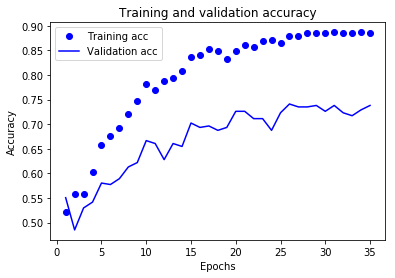

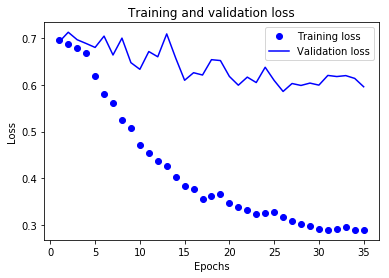

In [35]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show();

## Evaluation on test set

In [36]:
results = model.evaluate(X_test, y_test)

420/420 [==============================] - 1s 3ms/step


In [37]:
loss = results[0]
accuracy = results[1]

In [38]:
loss

0.5482384920120239

In [39]:
accuracy

0.7547619047619047

## Save the model and tokenizer

In [40]:
model.save("HospitalErrorDetectionClassifier.h5")

In [41]:
with open('HospitalErrorDetectionTokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL, fix_imports=True)